# Data Science Bowl: Detecting Lung Cancer From Chest Scans

In [1]:
import numpy as np
import pandas as pd
import os
import scipy.ndimage
import matplotlib.pyplot as plt
import warnings
from glob import glob

from skimage import measure, morphology
from skimage.transform import resize

from keras.models import Model
from keras.layers import Input, Dense, Convolution2D, MaxPooling2D, UpSampling2D, merge
from keras.optimizers import Adam
from keras import backend as K

%matplotlib inline
warnings.filterwarnings("ignore")



luna_path = '/Volumes/solo/Luna16/'
luna_subset_path = luna_path + 'subset0/'
df_node = pd.read_csv(luna_path + 'CSVFILES/' + 'annotations.csv')

file_list = glob(luna_subset_path + "*.mhd")
npy_list=glob(luna_path + 'npy/' + "images_*.npy")


INPUT_FOLDER = luna_subset_path
patients = os.listdir(INPUT_FOLDER)
patients.sort()

Using TensorFlow backend.


## Utils

In [2]:
def load_scan(path):
    slices = [dicom.read_file(path + '/' + s) for s in os.listdir(path)]
    slices.sort(key = lambda x: int(x.InstanceNumber))
    try:
        slice_thickness = np.abs(slices[0].ImagePositionPatient[2] - slices[1].ImagePositionPatient[2])
    except:
        slice_thickness = np.abs(slices[0].SliceLocation - slices[1].SliceLocation)
        
    for s in slices:
        s.SliceThickness = slice_thickness
        
    return slices


def get_pixels_hu(scans):
    image = np.stack([s.pixel_array for s in scans])
    image = image.astype(np.int16)

    # Set outside-of-scan pixels to 0
    # The intercept is usually -1024, so air is approximately 0
    image[image == -2000] = 0
    
    # Convert to Hounsfield units (HU)
    intercept = scans[0].RescaleIntercept
    slope = scans[0].RescaleSlope
    
    if slope != 1:
        image = slope * image.astype(np.float64)
        image = image.astype(np.int16)
        
    image += np.int16(intercept)   
    return np.array(image, dtype=np.int16)


def get_batches(patients):
    for ix, patient in enumerate(patients):
        scan = load_scan(INPUT_FOLDER + patient)
        slices = get_pixels_hu(scan)
        if ix % 50 == 0:
            print("Processed patient {0} of {1}".format(ix, len(patients)))
        yield slices
        

def save_array(path, arr):
    np.save(path, arr)
    

def load_array(path):
    return np.load(path)

## Preprocessing

#### Normalization & Centering

In [3]:
MIN_BOUND = -1000.0
MAX_BOUND = 400.0
PIXEL_MEAN = 0.25
    
def normalize(image):
    image = (image - MIN_BOUND) / (MAX_BOUND - MIN_BOUND)
    image[image>1] = 1.
    image[image<0] = 0.
    return image

def zero_center(image):
    image = image - PIXEL_MEAN
    return image

#### Lung Masks

In [4]:
def largest_label_volume(im, bg=-1):
    vals, counts = np.unique(im, return_counts=True)

    counts = counts[vals != bg]
    vals = vals[vals != bg]

    biggest = vals[np.argmax(counts)]
    return biggest


def segment_lung_mask(image, fill_lung_structures=True): 
    # not actually binary, but 1 and 2. 
    # 0 is treated as background, which we do not want
    binary_image = np.array(image > -350, dtype=np.int8)+1
    labels = measure.label(binary_image)
    
    # Pick the pixel in the very corner to determine which label is air.
    #   Improvement: Pick multiple background labels from around the patient
    #   More resistant to "trays" on which the patient lays cutting the air 
    #   around the person in half
    background_label = labels[0,0,0]
    
    #Fill the air around the person
    binary_image[background_label == labels] = 2
    
    # Method of filling the lung structures (that is superior to something like 
    # morphological closing)
    if fill_lung_structures:
        # For every slice we determine the largest solid structure
        for i, axial_slice in enumerate(binary_image):
            axial_slice = axial_slice - 1
            labeling = measure.label(axial_slice)
            l_max = largest_label_volume(labeling, bg=0)
            
            if l_max is not None: #This slice contains some lung
                binary_image[i][labeling != l_max] = 1

    binary_image -= 1  # Make the image actual binary
    binary_image = 1-binary_image # Invert it, lungs are now 1
    
    # Remove other air pockets insided body
    labels = measure.label(binary_image, background=0)
    l_max = largest_label_volume(labels, bg=0)
    
    if l_max is not None: # There are air pockets
        binary_image[labels != l_max] = 0
    
    for i, axial_slice in enumerate(binary_image):  # one last dilation
        binary_image[i] = morphology.dilation(axial_slice, np.ones([10,10]))
        
    return binary_image


def save_masks(scan, patient):
    masks = segment_lung_mask(scan, True)
    np.save("sample_masks/{}.npy".format(patient), masks)
    return masks

#### Apply Masks

In [5]:
def apply_masks(imgs, masks):
    out_images = []
    for i in range(len(imgs)):
        mask = masks[i]
        img = imgs[i]
            
        new_size = [512, 512]
        img= mask*img  # apply lung mask

        ### renormalizing the masked image (in the mask region)
        new_mean = np.mean(img[mask>0])  
        new_std = np.std(img[mask>0])
        
        ### Pulling the background color up to the lower end of pixel range for the lungs
        old_min = np.min(img)       # background color
        img[img==old_min] = new_mean-1.2*new_std   # resetting backgound color
        img = img-new_mean
        img = img/new_std
        
        ### make image bounding box  (min row, min col, max row, max col)
        labels = measure.label(mask)
        regions = measure.regionprops(labels)
        
        ### Finding the global min and max row over all regions
        min_row = 512
        max_row = 0
        min_col = 512
        max_col = 0
        for prop in regions:
            B = prop.bbox
            if min_row > B[0]:
                min_row = B[0]
            if min_col > B[1]:
                min_col = B[1]
            if max_row < B[2]:
                max_row = B[2]
            if max_col < B[3]:
                max_col = B[3]
        width = max_col-min_col
        height = max_row - min_row
        if width > height:
            max_row=min_row+width
        else:
            max_col = min_col+height
        
        ### cropping the image down to the bounding box for all regions
        img = img[min_row:max_row,min_col:max_col]
        mask =  mask[min_row:max_row,min_col:max_col]
        if max_row-min_row <5 or max_col-min_col<5:  # skipping all images with no good regions
            pass
        else:
            ### moving range to -1 to 1 to accomodate the resize function
            mean = np.mean(img)
            img = img - mean
            min = np.min(img)
            max = np.max(img)
            img = img/(max-min)
            new_img = resize(img, [512, 512])
            out_images.append(new_img)
    return out_images


def save_preprocessed(patient, scan, masks):
    masked = apply_masks(scan, masks)
    save_array("prepd_samples/{}.npy".format(patient), masked)

#### Run Preprocessing Pipeline

In [6]:
for img_file in npy_list:
    # 只能用float64，用float16归一化后都是0
    imgs_to_process = np.load(img_file).astype(np.float64) 

num_images = len(npy_list)
    #
    #  Writing out images and masks as 1 channel arrays for input into network
    #
imgs_to_process = np.ndarray([num_images,3, 512, 512], dtype=np.float32)

for i in range(num_images):
    imgs_to_process[i,:,:,:] = np.load(npy_list[i]).astype(np.float64) 

scan = imgs_to_process
final = imgs_to_process

In [7]:
scan = scan.reshape([num_images*3,512,512])

####  Preprocessing Pipeline Visualization

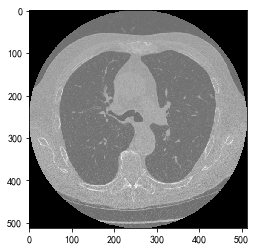

In [ ]:
im_index = 100                    # choose a random slice from somewhere near the middle of the scan


plt.imshow(scan[im_index], cmap=plt.cm.gray)

In [ ]:
normalized = normalize(scan)

plt.imshow(normalized[im_index], cmap=plt.cm.gray)

In [ ]:
centered = zero_center(normalized)

plt.imshow(centered[im_index], cmap=plt.cm.gray)

In [ ]:
mask = load_array('sample_masks/{}.npy'.format(patients[0]))

plt.imshow(mask[im_index], cmap=plt.cm.gray)

In [ ]:
final = load_array('prepd_samples/{}.npy'.format(patients[10]))  # picking one with cancer

plt.imshow(final[im_index], cmap=plt.cm.gray)

In [ ]:
f, plots = plt.subplots(10, 10, sharex='all', sharey='all', figsize=(10, 10))

for i in range(100):
    plots[i // 10, i % 10].axis('off')
    plots[i // 10, i % 10].imshow(final[i+10], cmap=plt.cm.gray)

In [ ]:
print("Example scan stats:\n")
print("Max pixel value:", np.max(final))
print("Min pixel value:", np.min(final))
print("Shape of full scan:", final.shape)

## Nodule Prediction & Masking

#### Define Custom Loss Function

In [ ]:
smooth = 1.

def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)


def dice_coef_np(y_true,y_pred):
    y_true_f = y_true.flatten()
    y_pred_f = y_pred.flatten()
    intersection = np.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (np.sum(y_true_f) + np.sum(y_pred_f) + smooth)


def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)

#### Build Unet Model

In [ ]:
def get_unet():
    inputs = Input((1, 512, 512))
    conv1 = Convolution2D(32, 3, 3, activation='relu', border_mode='same')(inputs)
    conv1 = Convolution2D(32, 3, 3, activation='relu', border_mode='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Convolution2D(64, 3, 3, activation='relu', border_mode='same')(pool1)
    conv2 = Convolution2D(64, 3, 3, activation='relu', border_mode='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Convolution2D(128, 3, 3, activation='relu', border_mode='same')(pool2)
    conv3 = Convolution2D(128, 3, 3, activation='relu', border_mode='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Convolution2D(256, 3, 3, activation='relu', border_mode='same')(pool3)
    conv4 = Convolution2D(256, 3, 3, activation='relu', border_mode='same')(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = Convolution2D(512, 3, 3, activation='relu', border_mode='same')(pool4)
    conv5 = Convolution2D(512, 3, 3, activation='relu', border_mode='same')(conv5)

    up6 = merge([UpSampling2D(size=(2, 2))(conv5), conv4], mode='concat', concat_axis=1)
    conv6 = Convolution2D(256, 3, 3, activation='relu', border_mode='same')(up6)
    conv6 = Convolution2D(256, 3, 3, activation='relu', border_mode='same')(conv6)

    up7 = merge([UpSampling2D(size=(2, 2))(conv6), conv3], mode='concat', concat_axis=1)
    conv7 = Convolution2D(128, 3, 3, activation='relu', border_mode='same')(up7)
    conv7 = Convolution2D(128, 3, 3, activation='relu', border_mode='same')(conv7)

    up8 = merge([UpSampling2D(size=(2, 2))(conv7), conv2], mode='concat', concat_axis=1)
    conv8 = Convolution2D(64, 3, 3, activation='relu', border_mode='same')(up8)
    conv8 = Convolution2D(64, 3, 3, activation='relu', border_mode='same')(conv8)

    up9 = merge([UpSampling2D(size=(2, 2))(conv8), conv1], mode='concat', concat_axis=1)
    conv9 = Convolution2D(32, 3, 3, activation='relu', border_mode='same')(up9)
    conv9 = Convolution2D(32, 3, 3, activation='relu', border_mode='same')(conv9)

    conv10 = Convolution2D(1, 1, 1, activation='sigmoid')(conv9)

    model = Model(input=inputs, output=conv10)

    model.compile(optimizer=Adam(lr=1.0e-5), loss=dice_coef_loss, metrics=[dice_coef])

    return model

#### Predict Nodule Locations

In [ ]:
def predict_on_scan(scan):
    model = get_unet()
    model.load_weights('pretrained_models/unet.hdf5')

    num_test = scan.shape[0]
    scan = scan.reshape(num_test, 1, 512, 512)
    imgs_mask_test = np.ndarray([num_test, 1, 512, 512],dtype=np.float32)
    for i in range(num_test):
        imgs_mask_test[i] = model.predict([scan[i:i+1]], verbose=0)[0]
    return imgs_mask_test

In [ ]:
pred = predict_on_scan(final).reshape(final.shape[0], 512, 512)  # using the same example patient as above

plt.imshow(pred[im_index], cmap=plt.cm.gray)

In [ ]:
f, plots = plt.subplots(10, 10, sharex='all', sharey='all', figsize=(10, 10))

for i in range(100):
    plots[i // 10, i % 10].axis('off')
    plots[i // 10, i % 10].imshow(pred[i+10], cmap=plt.cm.gray)

In [ ]:
# taking a closer look at one of the larger masks

plt.imshow(pred[109], cmap=plt.cm.gray)

In [ ]:
# looking at the original

plt.imshow(final[109], cmap=plt.cm.gray)

In [ ]:
# applying node mask to original image

node_masked = pred[109] * final[109]

plt.imshow(node_masked, cmap=plt.cm.gray)

So obviously we're picking up some stuff that we shouldn't, but might be on the right track at least...